# Analysis of Region Change-Points

This notebook first creates region sub-networks. To do this, I remove any nodes outside of the region and its direct trade partners. Then, the best trained S-GNN is applied to each of these sub-networks and the resulting change-points can be analyzed.

In [1]:
import sys
sys.path.append('/Users/sinclaireschuetze/Documents/GitHub/Trade-GNN-Thesis/src')
import pandas as pd
import numpy as np
import pickle as pkl
import datetime as datetime
import torch
from model import GraphSAGE, SiameseGNN
from utils.CreateFeatures import CreateFeatures
from utils.functions import dist_labels_to_changepoint_labels
from torch_geometric.utils import k_hop_subgraph

## Region Networks

In [ ]:
with open("../data/graphs/graphs_gdp.pkl", "rb") as f:         
    all_graphs = pkl.load(f)
    
countries = ['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD',
       'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB',
       'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA',
       'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FSM',
       'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI',
       'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA',
       'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU',
       'LUX', 'LVA', 'MAC', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL',
       'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MNP', 'MOZ', 'MRT',
       'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR',
       'NPL', 'NRU', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW',
       'PNG', 'POL', 'PRT', 'PRY', 'PSE', 'PYF', 'QAT', 'ROU', 'RUS',
       'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV', 'SMR',
       'SRB', 'SSD', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SWZ', 'SXM',
       'SYC', 'SYR', 'TCD', 'TGO', 'THA', 'TJK', 'TKM', 'TLS', 'TON',
       'TTO', 'TUN', 'TUR', 'TUV', 'TZA', 'UGA', 'UKR', 'URY', 'USA',
       'UZB', 'VCT', 'VEN', 'VNM', 'VUT', 'WSM', 'YEM', 'ZAF', 'ZMB',
       'ZWE']

In [ ]:
def load_model(model_path: str):
    """
    Loads trained model and encoder
    """

    encoder = GraphSAGE(27, 16, 0.1)
    encoder.load_state_dict(torch.load(f'{model_path}-encoder.pt'))
    model = SiameseGNN(encoder, 50, 27, dropout = 0.05, nhidden=16)
    model.load_state_dict(torch.load(f'{model_path}.pt'))

    return model

In [7]:
model = load_model('../saved-models/sage-gdp-mis_norm')
model.eval()

SiameseGNN(
  (encoder): GraphSAGE(
    (conv1): SAGEConv(27, 32, aggr=mean)
    (conv2): SAGEConv(32, 16, aggr=mean)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.05, inplace=False)
  (similarity): PairwiseDistance()
  (fc1): Linear(in_features=50, out_features=32, bias=True)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [15]:
#Get region (continent) for each country
country_codes = pd.read_excel("../data/ISO3166.xlsx")

#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]

locations = pd.read_stata("../data/location_classifications/location.dta")
locations['location_id'] = locations['location_id'].astype(int)
locations.drop(columns = ['location_id','location_name_short_en','level'], inplace = True)

df_with_regions = country_codes.merge(locations, left_on = "location_code", right_on = "location_code")
df_nodes = df_with_regions[df_with_regions['location_code'].isin(countries)] 
columns_to_keep = ["English short name","location_code","parent_id"]
df_columns = df_nodes[columns_to_keep]
df_columns.reset_index(drop=True, inplace=True)

In [17]:
#Creates dictionaries of countries in each region and node indices in each region
countries_by_region = {}
indices_by_region = {}
for i in countries:
    region = int(df_columns[df_columns['location_code']==i]['parent_id'].iloc[0])
    if region != 358: #region 358 is Antarctica, don't need to include that
        if region not in countries_by_region:
            countries_by_region[region] = [i]
        else:
            countries_by_region[region].append(i)

        #Gets node index of each country to be able to properly remove from network
        index = countries.index(i)
        index_np = np.int32(index)
        if region not in indices_by_region:
            indices_by_region[region] = [index_np]
        else:
            indices_by_region[region].append(index_np)

indices_by_region[352] = indices_by_region[352][:-2]
regions = list(countries_by_region.keys())

In [18]:
#Loads graphs and mis-norm feature dict
with open("../data/graphs/graphs_gdp.pkl", "rb") as f:         
    all_graphs = pkl.load(f)

with open("../feature_dicts/mis_norm.pkl", "rb") as f:
    feat_dict = pkl.load(f)

In [19]:
def add_features(years, graphs, feat_dict, dim):
    """
    For each row in x tensor of network, adds additional node features

    Returns set of graphs for all years
    """

    zeros = torch.zeros(dim)

    for i in range(len(years)):
        new_x = torch.empty(0, dim)
        year = years[i]
        
        feat_dict_year = feat_dict[year].combined_features

        for j, country in enumerate(countries):
            if j == 0:
                new_x = torch.stack([zeros])

            elif country in feat_dict_year["country_code"].values:
                tensor_before = graphs[i].x[j]
                country_row = feat_dict_year[feat_dict_year["country_code"] == country]
                country_row = country_row.drop(columns = ["country_code", "current_gdp_growth"])
                row_values = country_row.values.tolist()
                row_tensor = torch.tensor(row_values)[0]
                combined_values = torch.cat((tensor_before, row_tensor))

                new_x = torch.cat((new_x, combined_values.unsqueeze(0)), dim=0)

            else:
                new_x = torch.cat((new_x, zeros.unsqueeze(0)), dim=0)

        graphs[i].x = new_x

    return graphs

In [22]:
#Creates dictionary with graphs by region where only the nodes within a region and their direct neighbors are kept
years = range(1962,2019)
sub_graphs_by_region = {}
regions = list(countries_by_region.keys())
for r in regions:
    with open("../data/graphs/graphs_gdp.pkl", "rb") as f:         
        all_graphs = pkl.load(f)
        all_graphs = add_features(years, all_graphs, feat_dict, 27)
    sub_graphs_by_region[r] = []
    for i in range(57):
        example_edge_index = all_graphs[i].edge_index
        edge_index = example_edge_index.to(torch.int32)
        ex_nodes = indices_by_region[r]
            
        subset, new_edge_index, mapping, edge_mask = k_hop_subgraph(node_idx=ex_nodes, num_hops = 1, edge_index=edge_index)
        temp_graph = all_graphs[i]
        temp_graph.edge_index = new_edge_index
        sub_graphs_by_region[r].append(temp_graph)

In [23]:
crisis_years = [1973, 1991, 1995, 2000, 2007, 2016, 2018]
phases = []
p = -1
for i in range(1962,2019):
    if i in crisis_years:
        p += 1
    phases.append(p)

cp_times = [t-1962 for t in crisis_years]
labels = dist_labels_to_changepoint_labels(phases)

In [40]:
import json
with open(f'../data/region-graphs/region-352/graphs.p', 'wb') as f:
    pkl.dump(sub_graphs_by_region[352], f)

with open(f'../data/region-graphs/region-352/labels.p', 'wb') as f:
    pkl.dump(labels, f)

with open(f'../data/region-graphs/region-352/cp-times.json', 'w') as f:
    json.dump(cp_times, f)

In [44]:
change_points = {}
similarity_scores_norm_gdp = {}

for r in [353, 356, 352]:
    with open(f"../cpd-results/region-results/region-{r}/avg_similarity.p", 'rb') as file:
        avg_sim = pkl.load(file)
        similarity_scores_norm_gdp[r] = avg_sim

    with open(f"../cpd-results/region-results/region-{r}/est_cps.p", 'rb') as file:
        cps = pkl.load(file)
        adj = [i+1962 for i in cps]
        change_points[r] = adj

In [45]:
region_mappings = {354:'Oceania',
                   353:'Asia',
                   352:'Africa',
                   355:'Europe',
                   356:'North America',
                   357:'South America'}

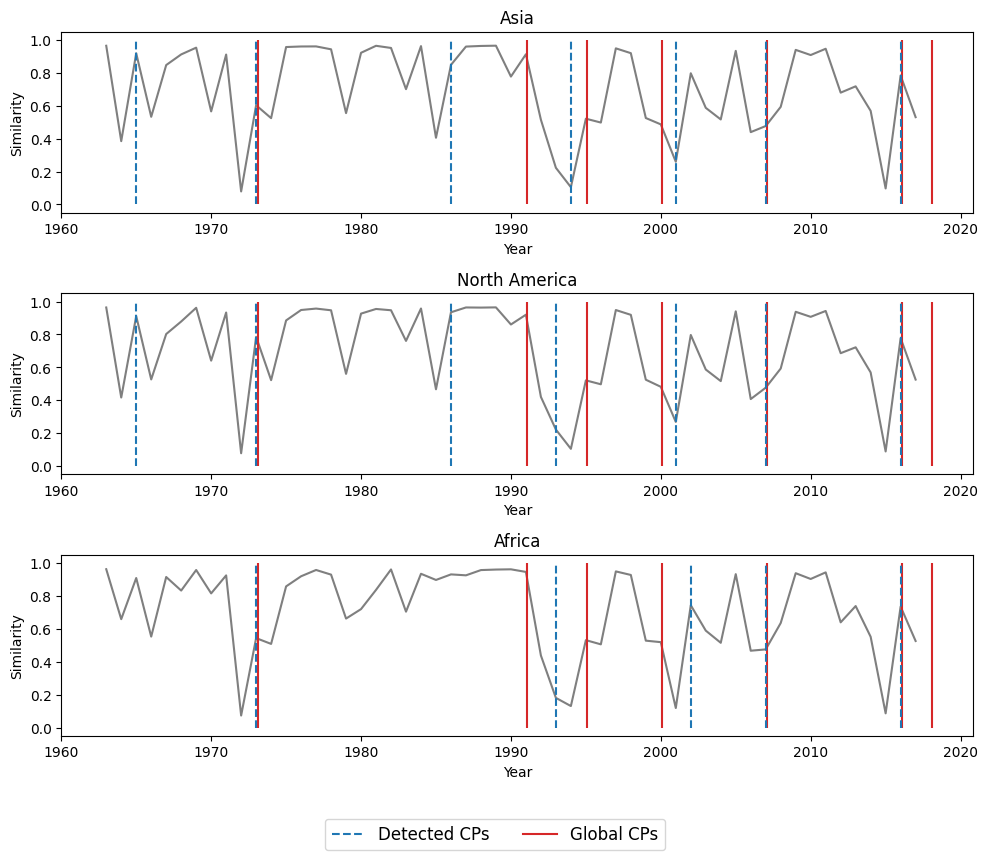

In [54]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10,8))
times = range(1963,2018)
selected_times = crisis_years

regions = [353, 356, 352]
for j,i in enumerate(regions):
    # Plot just one line, for example, the LAD line
    axs[j].plot(times, similarity_scores_norm_gdp[i], label=f'Region {region_mappings[i]}', color='tab:grey')
    adjusted_cps = [i+0.1 for i in selected_times]

    axs[j].vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='Global CPs', color='tab:red')
    axs[j].vlines(x=change_points[i], ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')

    axs[j].grid(visible=False)
    axs[j].set_xlabel(rf'Year')
    axs[j].set_ylabel(rf'Similarity')
    axs[j].set_title(f'{region_mappings[i]}')

    axs[j].set_xticks(range(1960, 2021, 10))

    handles = [mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Detected CPs'),
               mlines.Line2D([], [], color='tab:red', linestyle='-', label='Global CPs')]

# Add the legend to the figure
fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.08), fontsize='large')

plt.tight_layout()
plt.show()